## Descomposición de series temporales

El objetivo de este notebook es descomponer una serie temporal es sus componentes:

1) Componete de tendencia

2) Componente estacionaria

3) Componente de ruido


Usando estas componente podemos realizar una estimación a futuro de la serie asumiendo diferents modelos, aditivo, multiplicativo, etcetera.


In [1]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
matplotlib.rcParams['figure.figsize'] = [20, 10]
matplotlib.rcParams['font.size'] = 20

## Bajando un dataset

Trabajaremos con un dataset que puedes escontrar [aquí](https://machinelearningmastery.com/decompose-time-series-data-trend-seasonality/). Este dataset nos muestra ventas mensuales de coches en Quebec desde 1960 a 1968.


In [3]:
## bajando el dataset
cars_df = pd.read_csv("data/monthly-car-sales-in-quebec-1960.csv")
cars_df.tail()

,Month,Monthly car sales in Quebec 1960-1968
104,1968-09,14385.0
105,1968-10,21342.0
106,1968-11,17180.0
107,1968-12,14577.0
108,Monthly car sales in Quebec 1960-1968,NaN


## A) Limpiando el dataset

Eliminamos la última fila

In [4]:
cars_df = cars_df.iloc[:-1]

Cambiamos formato de fechas para que se visualice mejor

In [5]:
cars_df["dt"] = cars_df["Month"].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m'))

Cambiamos nombre de la columna `Monthly car sales in Quebec 1960-1968` for just `sales`  y eliminamos la columna `Month`.

In [6]:
cars_df = cars_df\
    .rename({"Monthly car sales in Quebec 1960-1968": "sales"}, axis=1)\
    .drop("Month", axis=1)
cars_df.tail()

,sales,dt
103,16722.0,1968-08-01
104,14385.0,1968-09-01
105,21342.0,1968-10-01
106,17180.0,1968-11-01
107,14577.0,1968-12-01


 Verificamos que no tenemos datos faltantes: 12 datos por año

In [7]:
cars_df[['dt']].groupby(cars_df["dt"].dt.year).count()

,dt
dt,
1960,12
1961,12
1962,12
1963,12
1964,12
1965,12
1966,12
1967,12
1968,12


Dibujamos la serie temporal

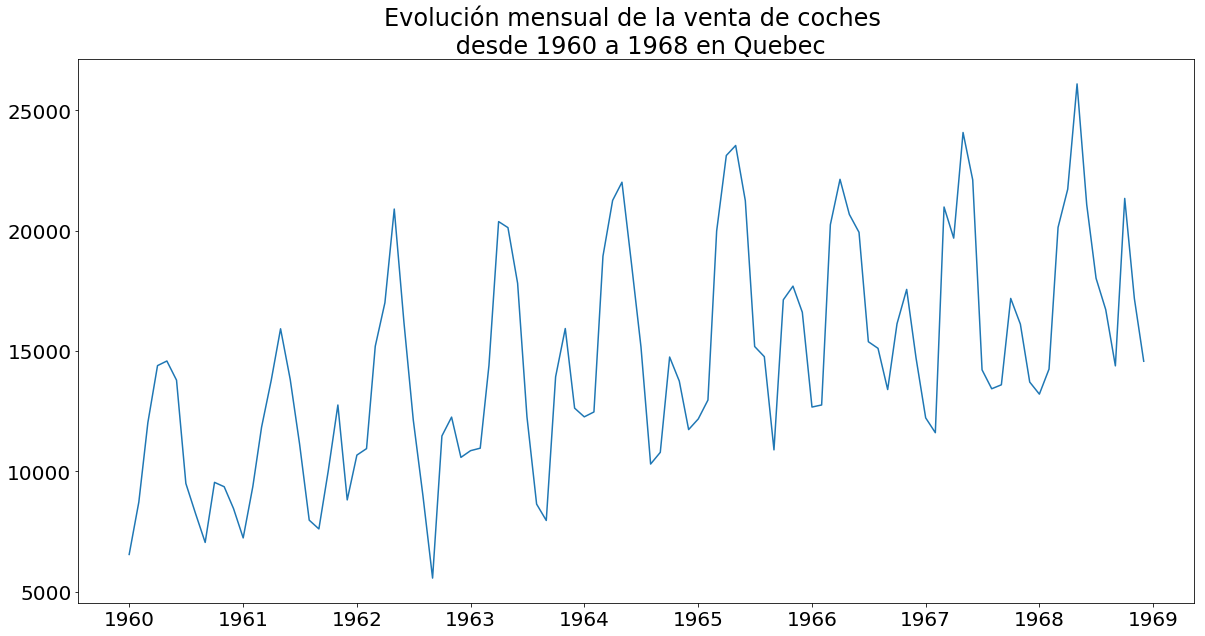

In [8]:
plt.plot(cars_df["dt"], cars_df["sales"])
plt.title("Evolución mensual de la venta de coches \n desde 1960 a 1968 en Quebec")
plt.show()

**Nota:**

Observando el plot se ve claramente que es una serie no estacionaria
con tendencia positiva y con periodos estacionales de un año.

Presuponemos claramente que el modelo es aditivo:

$X_t = E_t + T_t + I_t$

### 1) Desestacionalización de la serie

La clave es buscar el periodo y restarselo.

In [9]:
N_lags = 12
Xy = cars_df[['dt', 'sales']]

def create_lags(Xy, n_lags):
    Xy_with_lags = Xy.sort_values('dt').copy()
    for i in range(1, n_lags+1):
        Xy_with_lags['sales-'+str(i)] = Xy_with_lags['sales'].shift(i)
    return Xy_with_lags

Xy_with_lags = create_lags(Xy, N_lags).iloc[N_lags:]
Xy_with_lags.head()

,dt,sales,sales-1,sales-2,sales-3,sales-4,sales-5,sales-6,sales-7,sales-8,sales-9,sales-10,sales-11,sales-12
12,1961-01-01,7237.0,8456.0,9364.0,9545.0,7049.0,8251.0,9498.0,13791.0,14587.0,14395.0,12026.0,8728.0,6550.0
13,1961-02-01,9374.0,7237.0,8456.0,9364.0,9545.0,7049.0,8251.0,9498.0,13791.0,14587.0,14395.0,12026.0,8728.0
14,1961-03-01,11837.0,9374.0,7237.0,8456.0,9364.0,9545.0,7049.0,8251.0,9498.0,13791.0,14587.0,14395.0,12026.0
15,1961-04-01,13784.0,11837.0,9374.0,7237.0,8456.0,9364.0,9545.0,7049.0,8251.0,9498.0,13791.0,14587.0,14395.0
16,1961-05-01,15926.0,13784.0,11837.0,9374.0,7237.0,8456.0,9364.0,9545.0,7049.0,8251.0,9498.0,13791.0,14587.0


In [10]:
Xy_with_lags["diff12"] = Xy_with_lags["sales"] - Xy_with_lags["sales-12"]

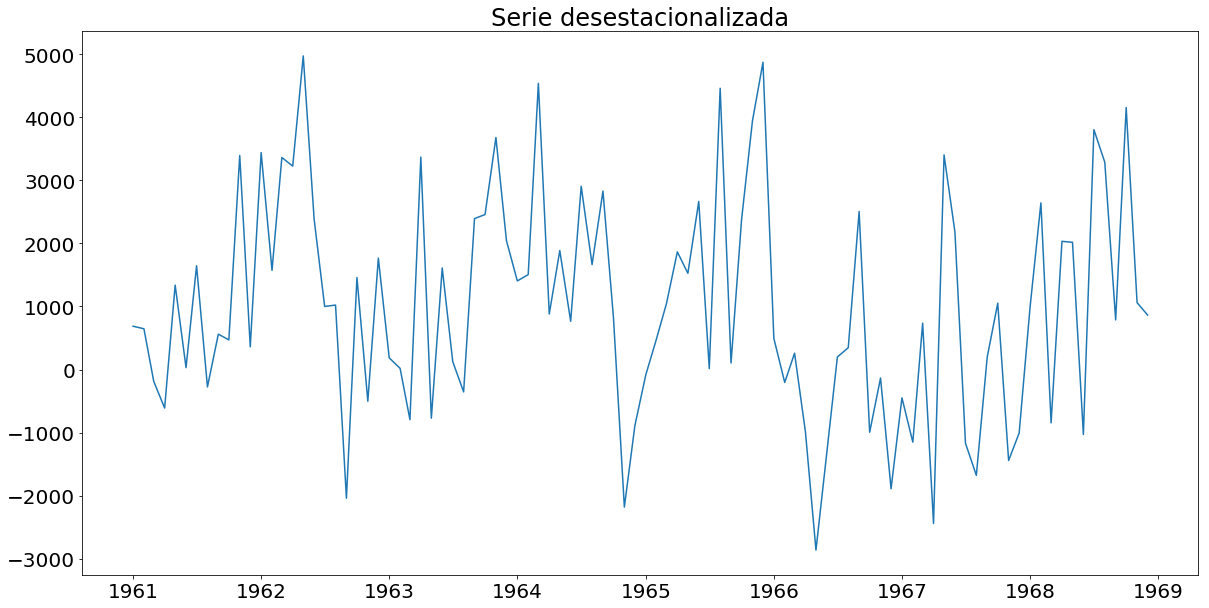

In [11]:
plt.plot(Xy_with_lags["dt"], Xy_with_lags["diff12"])
plt.title("Serie desestacionalizada")
plt.show()

2) Moving average

In [12]:
Xy_with_lags['mean'] = Xy_with_lags.drop(['dt','sales-12', 'diff12'], axis=1).mean(axis=1)

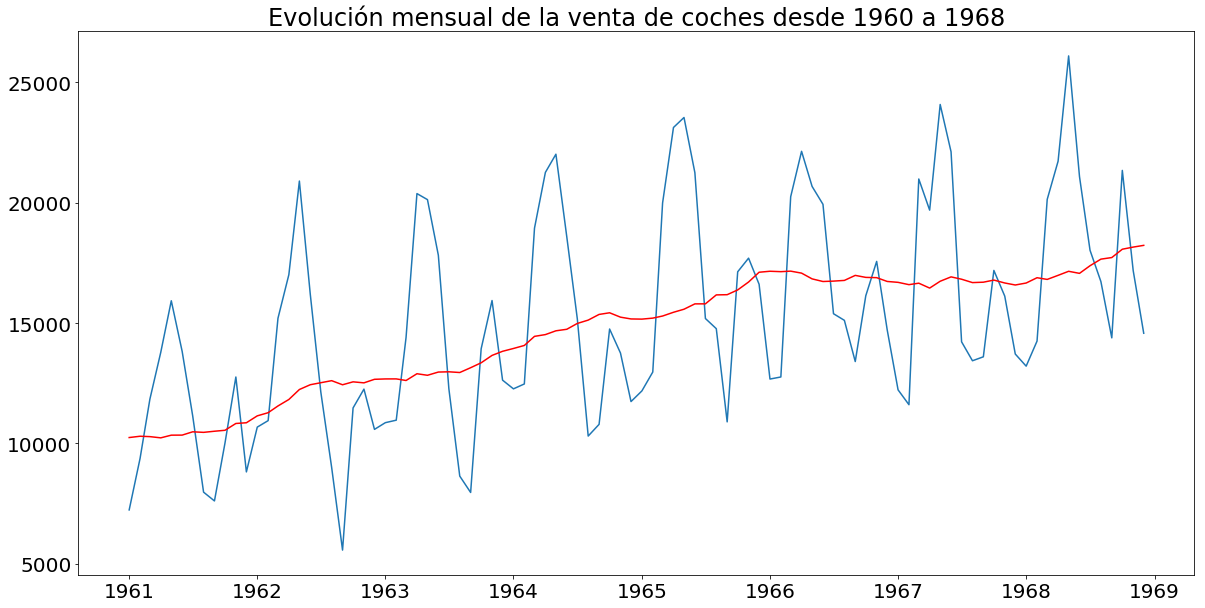

In [13]:
plt.plot(Xy_with_lags["dt"], Xy_with_lags["sales"])
plt.plot(Xy_with_lags["dt"], Xy_with_lags["mean"],color="red")
plt.title("Evolución mensual de la venta de coches desde 1960 a 1968")
plt.show()

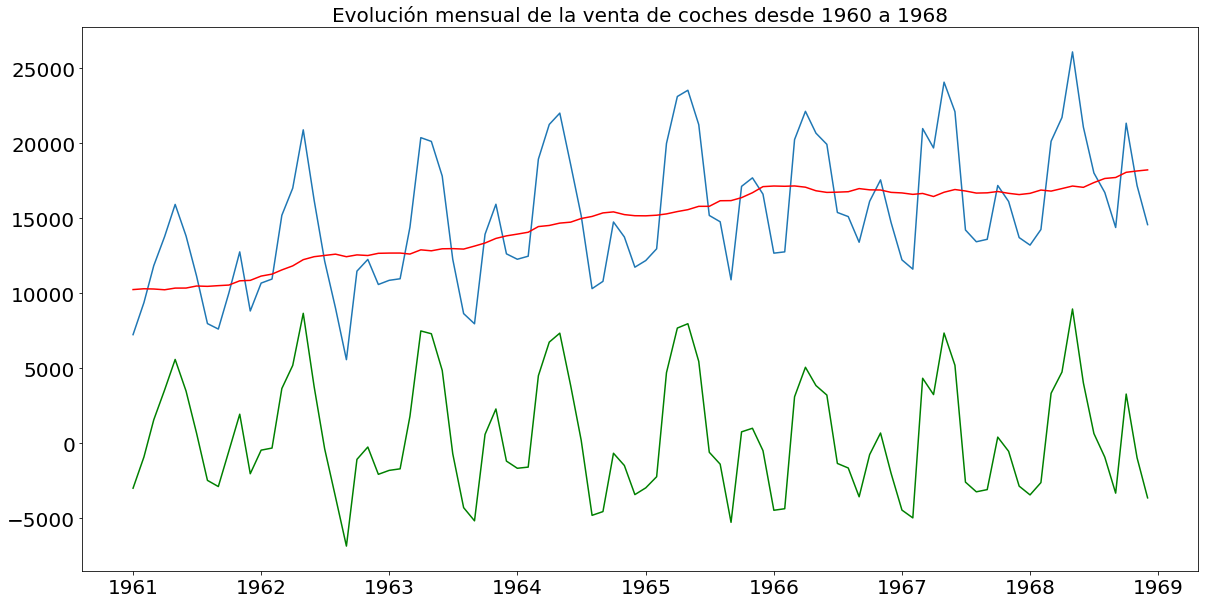

In [14]:
plt.plot(Xy_with_lags["dt"], Xy_with_lags["sales"])
plt.plot(Xy_with_lags["dt"], Xy_with_lags["mean"],color="red")
plt.plot(Xy_with_lags["dt"], Xy_with_lags["sales"]-Xy_with_lags["mean"],color="green")
plt.title("Evolución mensual de la venta de coches desde 1960 a 1968",size=20)
plt.show()

In [15]:
Xy_with_lags['seasonal'] = Xy_with_lags["sales"] - Xy_with_lags["mean"]
Xy_with_lags['month'] = Xy_with_lags["dt"].dt.month
Xy_seasons = Xy_with_lags[['month', 'seasonal']].copy()
#Xy_seasons_m12 = Xy_with_lags[['month', 'seasonal']].copy()
#Xy_seasons_m12["month"] = Xy_seasons_m12["month"] - 12
#Xy_seasons_12 = Xy_with_lags[['month', 'seasonal']].copy()
#Xy_seasons_12["month"] = Xy_seasons_12["month"] + 12
#Xy_seasons = pd.concat([Xy_seasons, Xy_seasons_m12, Xy_seasons_12])\
#    .query("month ")

In [16]:
max_degree = 10
for i in range(2, max_degree + 1):
    Xy_seasons['month'+str(i)] =  Xy_seasons['month']**i

In [17]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression()
reg.fit(Xy_seasons.drop(['seasonal'],axis=1),Xy_seasons['seasonal'])
seasonal_hat = reg.predict([[month**i for i in range(1, max_degree+1)] 
                 for month in range(1, 13)])
seasonal_hat_df = pd.DataFrame({
        'month': range(1, 13),
        'seasonal_hat': seasonal_hat
    })

In [18]:
Xy_with_lags_total = Xy_with_lags.merge(seasonal_hat_df).sort_values('dt')

In [19]:
Xy_with_lags_total['residual'] = Xy_with_lags_total['seasonal']-Xy_with_lags_total['seasonal_hat']

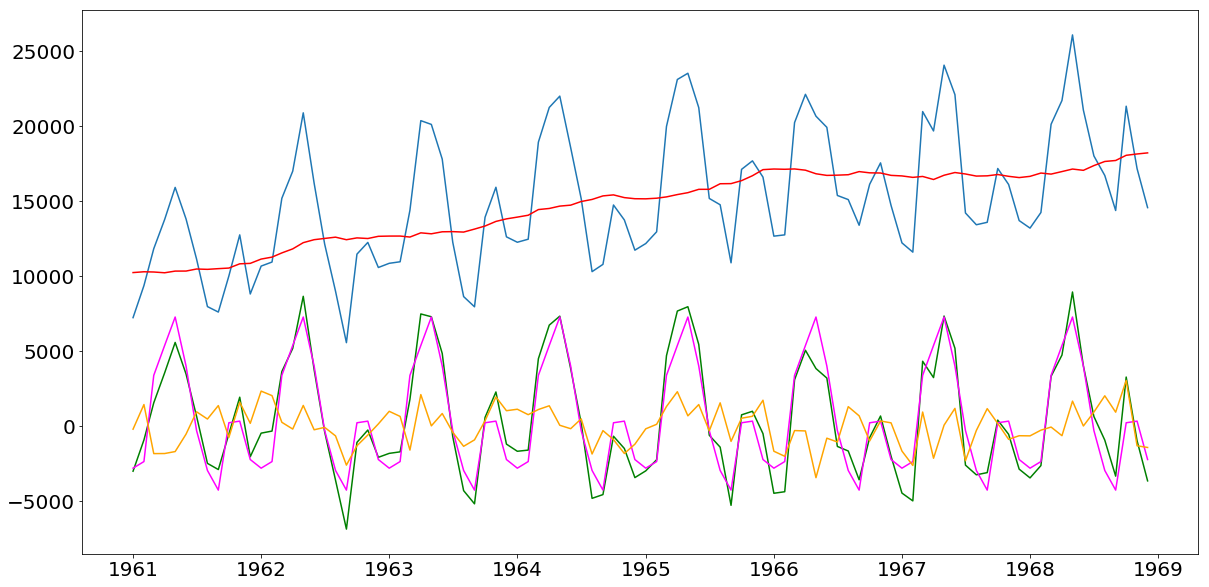

In [20]:
plt.plot(Xy_with_lags_total["dt"], Xy_with_lags_total["sales"])
plt.plot(Xy_with_lags_total["dt"], Xy_with_lags_total["mean"],color="red")
plt.plot(Xy_with_lags_total["dt"], Xy_with_lags_total["seasonal"],color="green")
plt.plot(Xy_with_lags_total["dt"], Xy_with_lags_total["seasonal_hat"],color="magenta")

plt.plot(Xy_with_lags_total["dt"], Xy_with_lags_total["residual"],color="orange")
plt.show()

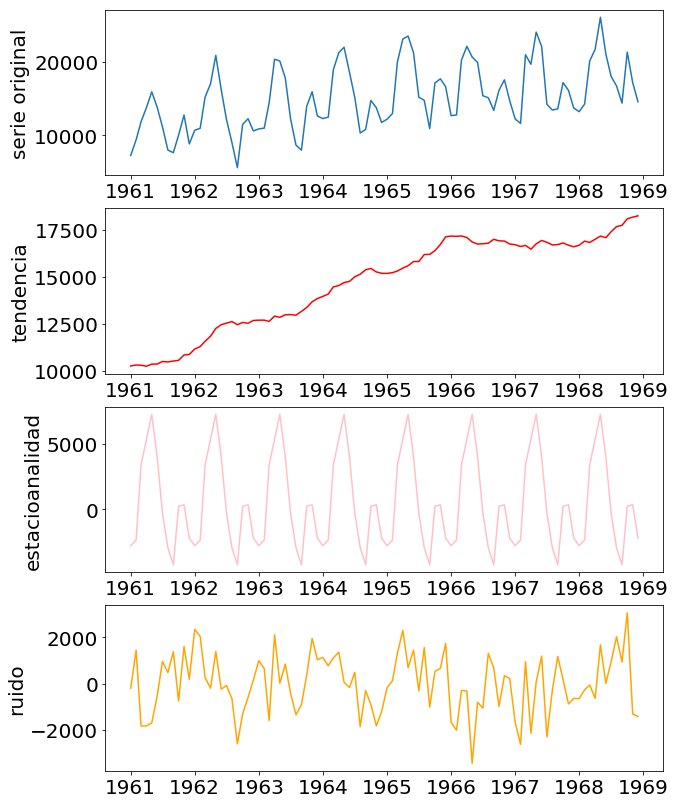

In [21]:
fig,ax = plt.subplots(nrows=4, ncols=1,figsize=(10,14))
ax[0].plot(Xy_with_lags_total["dt"], Xy_with_lags_total["sales"])
ax[0].set_ylabel("serie original",size=20)
ax[1].plot(Xy_with_lags_total["dt"], Xy_with_lags_total["mean"],color="red")
ax[1].set_ylabel("tendencia",size=20)
ax[2].plot(Xy_with_lags_total["dt"], Xy_with_lags_total["seasonal_hat"],color='pink')
ax[2].set_ylabel("estacioanalidad",size=20)
ax[3].plot(Xy_with_lags_total["dt"], Xy_with_lags_total["residual"],color='orange')
ax[3].set_ylabel("ruido",size=20)
plt.show()

## Descomposición de una serie de tiempo  usando un paquete de python

In [22]:
from pandas import Series
from statsmodels.tsa.seasonal import seasonal_decompose

In [23]:
series = Xy.set_index('dt')
result = seasonal_decompose(series, model='additive')

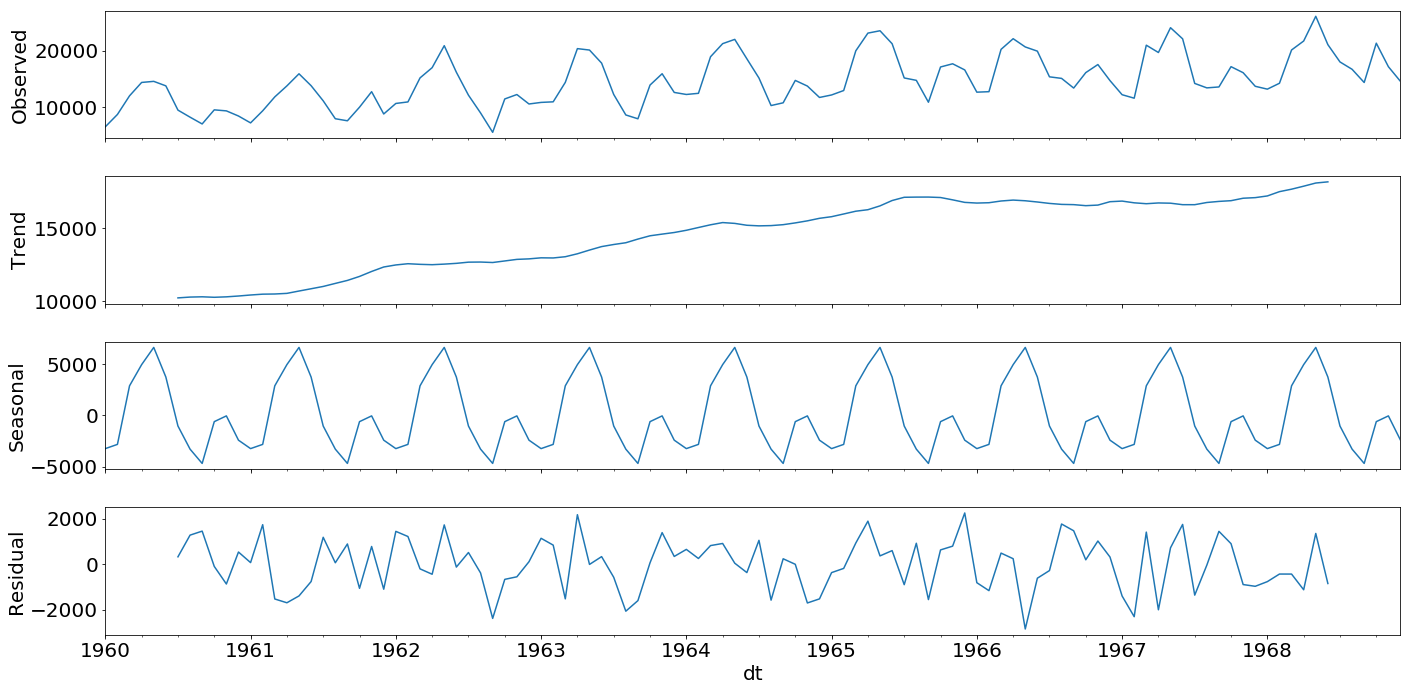

In [24]:
result.plot()
plt.show()